# Multiclass Ball Classification 

## This model walks through the demonstration of ResNet50 model

### Why I have used ResNet50?

The demonstration is based on knowledge gained from one task (source task) to a different but similar task (target task) in short a Transfer Learning Process.

When Transfer Learning is done we generally used a pretrained model and add the FCN (Fully Connected Layer)

ResNet50 model was used considering the trained on more than 1 million images from the ImageNet database. Just like VGG-19, it can classify up to 1000 objects and the network was trained on 224x224 pixels colored images.(https://arxiv.org/abs/1512.03385)


In [ ]:
# Adding Necessary Libraries

In [32]:
import os

import numpy as np 
import pandas as pd

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import glob

In [ ]:
# Creating the path structure

In [3]:
base_path = "balls"

train_dir = f"{base_path}/train"
test_dir = f"{base_path}/test"
val_dir = f"{base_path}/valid"

In [4]:
train_dir

'balls/train'

In [31]:
## Some Basic EDA perfomed over the set of given dataset

In [5]:
df = pd.read_csv("balls/balls.csv")
df.head()

,filepaths,labels,data set
0,train/baseball/001.jpg,baseball,train
1,train/baseball/002.jpg,baseball,train
2,train/baseball/003.jpg,baseball,train
3,train/baseball/004.jpg,baseball,train
4,train/baseball/005.jpg,baseball,train


In [6]:
df.shape

(3100, 3)

In [7]:
dataset_count = df['data set'].value_counts()

In [8]:
dataset_count

train    2860
test      120
valid     120
Name: data set, dtype: int64

In [9]:
## Total Number of classes
total_classes= os.listdir(train_dir)
len(total_classes)

24

In [10]:
train_images = glob.glob(f"{train_dir}/*/*.jpg")
test_images = glob.glob(f"{test_dir}/*/*.jpg")
val_images = glob.glob(f"{val_dir}/*/*.jpg")

## Plotting different classes of balls for the general Understanding of classes

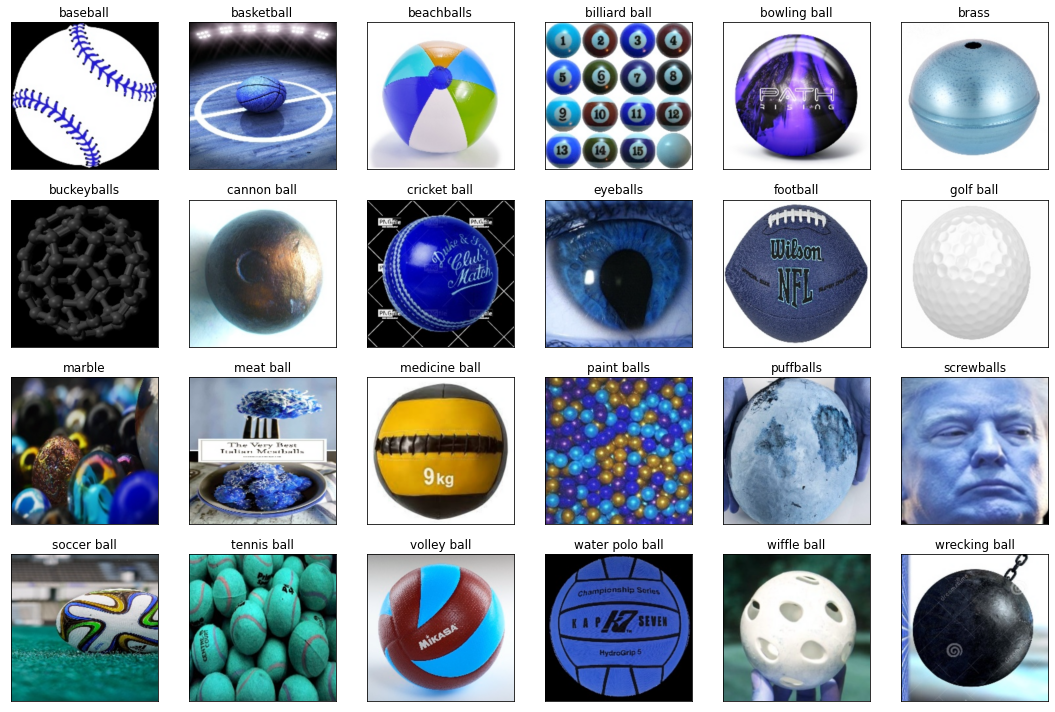

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i,ax in enumerate(axes.flat):
    images = os.listdir(os.path.join(train_dir, total_classes[i]))
    img = cv2.imread(os.path.join(train_dir, total_classes[i], images[i]))
    img = cv2.resize(img, (512,512))
    ax.imshow(img)
    ax.set_title(total_classes[i])
fig.tight_layout()    
plt.show()

## Data Augmentation

### Why I have used Data Augmentation techniques?

Data Augmentation helps to expand the size of training dataset by adding variations to the same data. E.g If the training dataset have the horses head towards right direction but while comparing it with the real world imagery which has a horse image in it with heads in a left direction the model wont be able to predict well.

Different types data augmentation techniques can be used in order to maake model trained on unseen scenerios.

In the cell below I am creating batches and vclass mode is categorical because we have to classify it into different number of class. For this dataset we have 24 classes


In [12]:
train_datagen = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)

val_datagen = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)

test_datagen = ImageDataGenerator(rotation_range=2, horizontal_flip= True, zoom_range=.1)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (220, 220))
validation_generator = val_datagen.flow_from_directory(val_dir, batch_size=20, class_mode = 'categorical', target_size=(220, 220))
test_generator = test_datagen.flow_from_directory(test_dir,shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(220, 220))

Found 2860 images belonging to 24 classes.
Found 120 images belonging to 24 classes.
Found 120 images belonging to 24 classes.


## Below cell talks about input shape and Learning rate Annelear

Learning rate annelear has been applied as a part of a callback which can help to monitor a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.


In [13]:
input_shape = (220, 220, 3)
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5)

## Model Preparation

#### 1) Used ResNet50 as a base model and kept the FCN empty which is created using few dense layers

#### 2) Global Average pooling is added because it gives single value for feature map and keeps the dimensions as it is 

e.g we have dimension of i/p layer as (H X W X D) , it takes the Global Average across Height and Width and gives you a tensor with dimensions of (1 x D) 

#### 3) One of the activation function used in ReLu (Rectified Linear Unit):

--> a) It interinterspersed nonlinearity between many of the convolution layers 

b) If value is negative it will be given as zero (0) and varies till one
    
c)The main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at  the same time

### 4) Softmax Activation at last
Since this is multiclass classification and it has 24 classes , softmax function is used because softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels.

In [14]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = 'relu'))
# model.add(Dropout(0.2))   =====> Reguralization Technique
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.2))
model.add(Dense(24, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 24)                3096      
Total params: 24,722,072
Trainable params: 1,134,360
Non-trainable params: 23,587,712
____________________________________

## Compilation of the model with optimizer

#### 1) Stochastic Gradient Descent:
It’s a variant of Gradient Descent. It tries to update the model’s parameters more frequently. 
In this, the model parameters are altered after computation of loss on each training example.

We can use different optimizers and have better understanding of how model can perform under them. each one have their own pro's and con's

In [15]:
learn_rate=.001
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)

## After compilation next step is to fit the model on training and validation dataset

In [16]:
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch = 100, epochs=30)

Epoch 1/30
100/100 [==============================] - 241s 2s/step - loss: 2.0656 - accuracy: 0.4820 - val_loss: 1.0190 - val_accuracy: 0.7583
Epoch 2/30
100/100 [==============================] - 288s 3s/step - loss: 0.6245 - accuracy: 0.8470 - val_loss: 0.4607 - val_accuracy: 0.8583
Epoch 3/30
100/100 [==============================] - 382s 4s/step - loss: 0.3429 - accuracy: 0.9135 - val_loss: 0.2457 - val_accuracy: 0.9417
Epoch 4/30
100/100 [==============================] - 277s 3s/step - loss: 0.2300 - accuracy: 0.9430 - val_loss: 0.2398 - val_accuracy: 0.9500
Epoch 5/30
100/100 [==============================] - 292s 3s/step - loss: 0.1667 - accuracy: 0.9605 - val_loss: 0.1972 - val_accuracy: 0.9417
Epoch 6/30
100/100 [==============================] - 318s 3s/step - loss: 0.1358 - accuracy: 0.9700 - val_loss: 0.1317 - val_accuracy: 0.9667
Epoch 7/30
100/100 [==============================] - 259s 3s/step - loss: 0.1129 - accuracy: 0.9765 - val_loss: 0.1444 - val_accuracy: 0.9500

### Plotting the Training vs validation loss

1)val_loss starts increasing, val_acc starts decreasing(means model is cramming values not learning)

2) val_loss starts increasing, val_acc also increases.(could be case of overfitting or diverse probability values in cases softmax is used in output layer)

3) val_loss starts decreasing, val_acc starts increasing(Correct, means model build is learning and working fine)

The above steps suggests that model is working fine

In [17]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

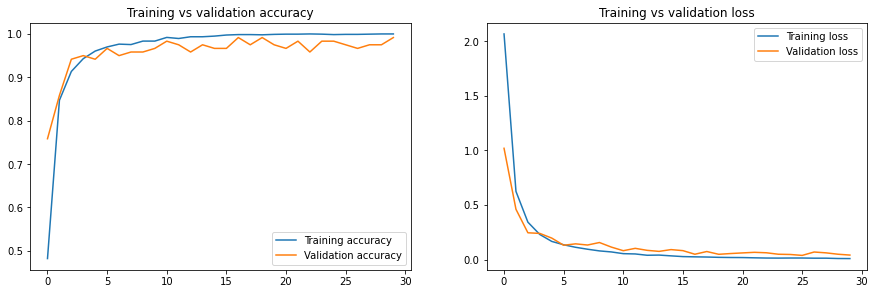

In [18]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()


### Prediction on the test dataset

In [19]:
pred = model.predict(test_generator)

In [20]:
pred

array([[9.8867947e-01, 1.4669678e-06, 1.4328816e-06, ..., 1.2175240e-11,
        7.4667867e-07, 4.3429696e-07],
       [9.9997854e-01, 5.4026465e-08, 6.0002900e-09, ..., 9.2605719e-13,
        8.5034759e-07, 5.0665278e-07],
       [9.9431121e-01, 4.3774244e-07, 5.7622089e-09, ..., 9.1034108e-10,
        2.5326874e-06, 2.5995038e-07],
       ...,
       [1.2471806e-05, 2.5523761e-06, 7.4301447e-08, ..., 2.0022961e-08,
        6.5886212e-08, 9.9958318e-01],
       [3.6757018e-07, 3.0754502e-06, 5.9622482e-07, ..., 1.0904789e-09,
        3.0195642e-09, 9.9985433e-01],
       [2.0096742e-03, 1.4438128e-05, 3.2132587e-07, ..., 1.3080248e-07,
        1.7306389e-08, 9.9640769e-01]], dtype=float32)

In [21]:
y_pred = np.argmax(pred, axis=1)
y_pred

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14, 15, 15, 19, 15, 15, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 21,
       20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23,
       23], dtype=int64)

In [22]:
y_pred_class = dict((v,k) for k,v in test_generator.class_indices.items())

In [23]:
y_pred_class

{0: 'baseball',
 1: 'basketball',
 2: 'beachballs',
 3: 'billiard ball',
 4: 'bowling ball',
 5: 'brass',
 6: 'buckeyballs',
 7: 'cannon ball',
 8: 'cricket ball',
 9: 'eyeballs',
 10: 'football',
 11: 'golf ball',
 12: 'marble',
 13: 'meat ball',
 14: 'medicine ball',
 15: 'paint balls',
 16: 'puffballs',
 17: 'screwballs',
 18: 'soccer ball',
 19: 'tennis ball',
 20: 'volley ball',
 21: 'water polo ball',
 22: 'wiffle ball',
 23: 'wrecking ball'}

In [24]:
y_pred = list(map(lambda x: y_pred_class[x], y_pred))

In [29]:
y_true = test_generator.classes
y_true = list(map(lambda x: y_pred_class[x], y_true))
print(classification_report(y_true, y_pred))

                 precision    recall  f1-score   support

       baseball       1.00      1.00      1.00         5
     basketball       1.00      1.00      1.00         5
     beachballs       1.00      1.00      1.00         5
  billiard ball       1.00      1.00      1.00         5
   bowling ball       1.00      1.00      1.00         5
          brass       1.00      1.00      1.00         5
    buckeyballs       1.00      1.00      1.00         5
    cannon ball       1.00      1.00      1.00         5
   cricket ball       1.00      1.00      1.00         5
       eyeballs       1.00      1.00      1.00         5
       football       1.00      1.00      1.00         5
      golf ball       1.00      1.00      1.00         5
         marble       1.00      1.00      1.00         5
      meat ball       1.00      1.00      1.00         5
  medicine ball       1.00      1.00      1.00         5
    paint balls       1.00      0.80      0.89         5
      puffballs       1.00    

In [25]:
results = model.evaluate(test_generator)

6/6 [==============================] - 13s 2s/step - loss: 0.0706 - accuracy: 0.9667


In [27]:
# serialize weights to HDF5
model.save_weights("Resnet_multiclass_ball.h5")